# Assignment 5: Block Matching and Harris Corner Detection
## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

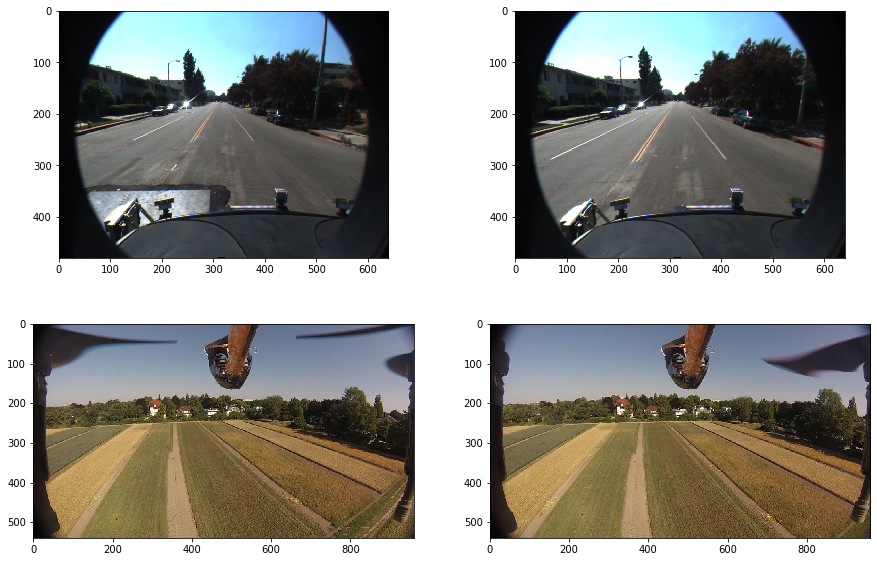

In [28]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
from scipy.ndimage.filters import sobel
import numpy as np
import math
import cv2

# Chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread('images/copter_flight/frame001.jpg')
copter2 = io.imread('images/copter_flight/frame002.jpg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)



## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture

* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

Finding harris...
Scaning frames.............

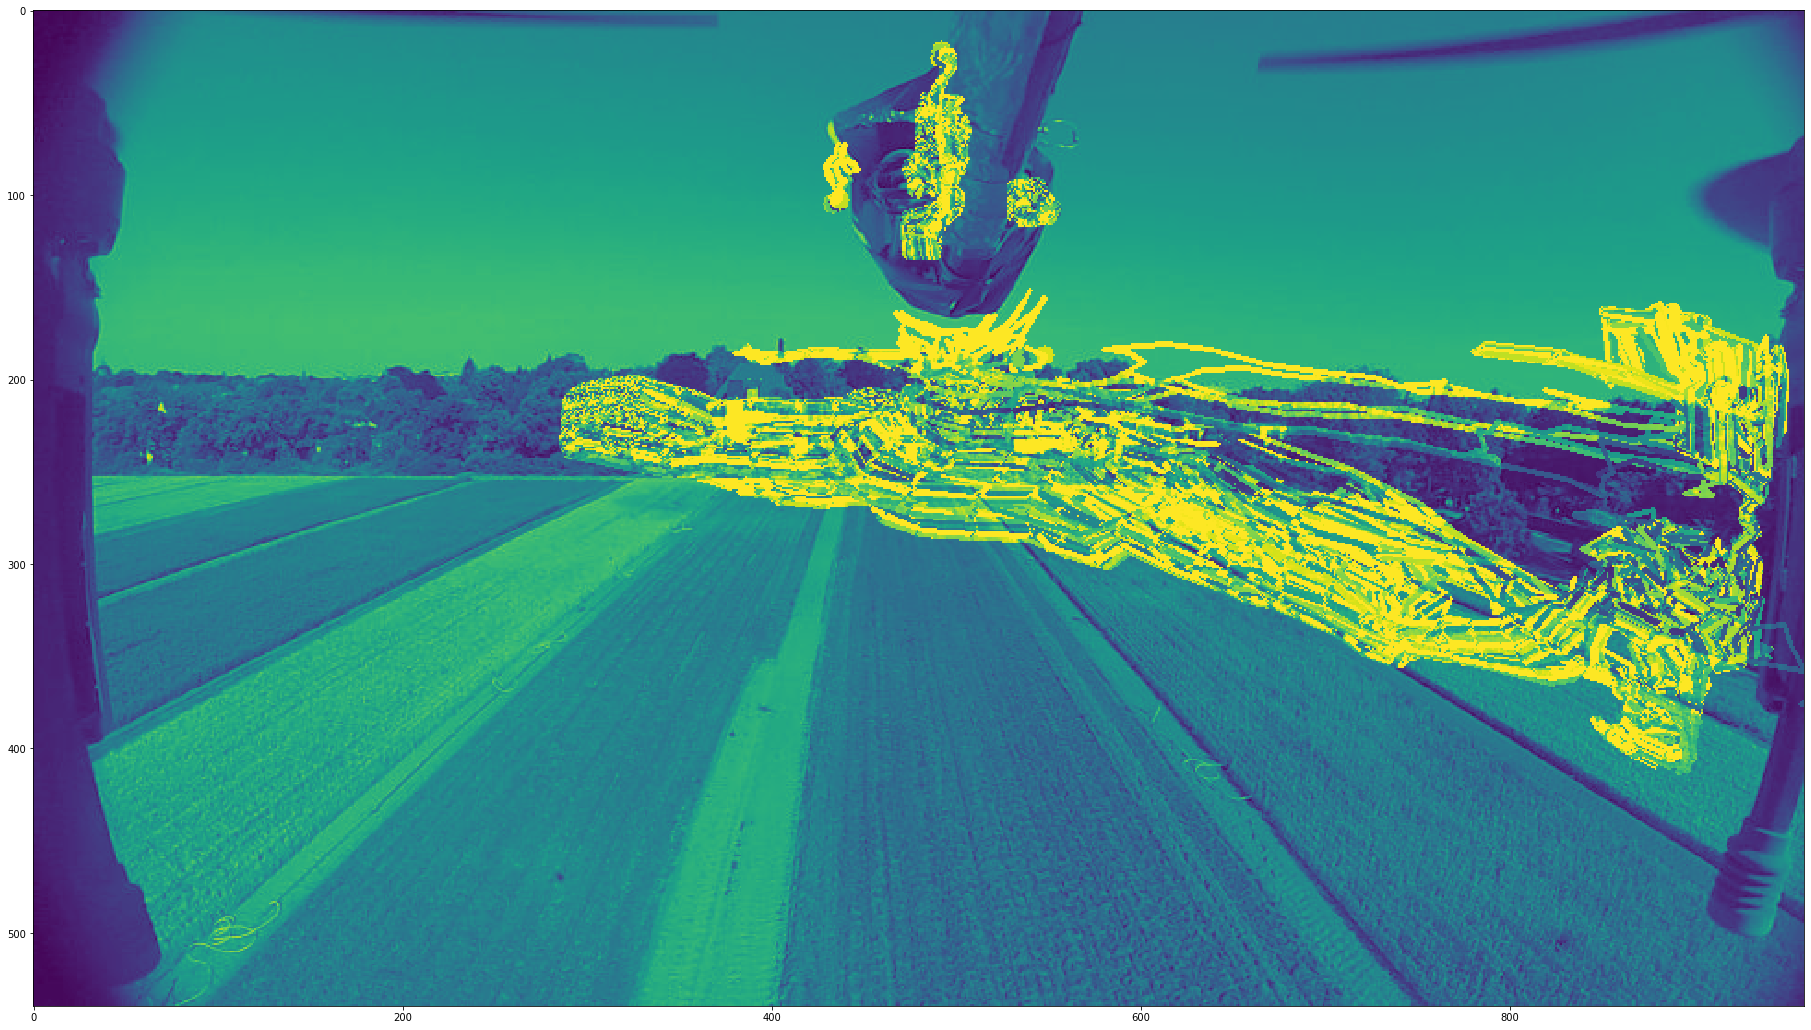

In [41]:
def _createEmptyH(img):
    _arr = np.zeros(img.shape, dtype= object)
    for i in range(0, len(_arr)):
        for u in range(0, len(_arr[0])):
            _arr[i][u] = np.zeros((2,2))
    return _arr

def devProducts(iX, iY):
    iX2 = iX*iX
    iY2 = iY*iY
    iYX = iY*iX
    return iX2, iY2, iYX


def sumWindow(y, x, matrix, windowSize):
    delta = windowSize // 2
    return matrix[y-delta: y+delta, x-delta: x+ delta].sum()

def findHarris(img):
    print("Finding harris...")
    windowSize = 20
    offset = windowSize//2
    k = 0.04
    threshHold = 10000
    iX = sobel(img, axis = 0, mode='constant')
    iY = sobel(img, axis = 1, mode='constant')
    iX2, iY2, iXY = devProducts(iX, iY)
    H = _createEmptyH(img)
    R = _createEmptyH(img)
    corners = []
    for i in range(offset, len(img)-offset):
        for u in range(offset, len(img[0])-offset):
            sX2 = sumWindow(i, u, iX2, windowSize)
            sY2 = sumWindow(i, u, iY2, windowSize)
            sXY = sumWindow(i, u, iXY, windowSize)
            H[i][u] = np.array([[sX2, sXY],[sXY, sY2]])
            singleR = (sX2*sY2 - np.square(sXY)) - (k * np.square(sX2 + sY2))
            if(singleR > threshHold): 
                corners.append([float(u), float(i)])
                R[i][u] = singleR
    return H, R, np.float32(np.array(corners))
def findAndDrawFlowVectors(p0, old_gray, firstFrame = 'images/copter_flight/frame001.jpg'):
    print("Scaning frames...", end='')
    colorTemp = np.random.randint(0,255,(38220,3))
    cap = cv2.VideoCapture(firstFrame, cv2.CAP_IMAGES)
    ret,frame = cap.read()
    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    lk_params = dict( winSize  = (20,20), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))    
    mask = np.zeros_like(old_gray)
    o = 0
    allPoints = []
    while(o<99):
        if(o%10==0): print('.', end='')
        ret,frame = cap.read()
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        allPoints.append(p1)
        good_new = p1#[st == 1]
        good_old = p0#[st == 1]
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), colorTemp[i].tolist(), 2)
            frame_gray = cv2.circle(frame_gray,(a,b),5,colorTemp[i].tolist(),-1)
            
        img = cv2.add(frame_gray,mask)

      #  cv2.imshow('frame',img)
      #  k = cv2.waitKey(30) & 0xff
      #  if k == 27:
      #      break

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
        o+=1
    return img

grayCopter = color.rgb2gray(copter1)

fig = plt.figure(figsize=(50, 50))
axis1 = plt.subplot(2, 2, 1)
H, R, corners = findHarris(grayCopter)
allPoints = findAndDrawFlowVectors(corners, grayCopter)

axis1.imshow(allPoints)
plt.tight_layout()
plt.show()
